In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import preprocessing as pre

from keras.layers import LSTM, Input, Dense, Dropout
from keras import Model, Sequential,layers

In [8]:
avlData = os.listdir("Data\\")
data = pd.read_csv(f"Data\\{avlData[1]}")
data.Date = pd.to_datetime(data.Date)
data = data.drop(columns = ["Volume"])
data

,Date,Open,High,Low,Close,Adj Close
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099449
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094261
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087343
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089504
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092099
...,...,...,...,...,...,...
10809,2023-10-27,166.910004,168.960007,166.830002,168.220001,168.220001
10810,2023-10-30,169.020004,171.169998,168.869995,170.289993,170.289993
10811,2023-10-31,169.350006,170.899994,167.899994,170.770004,170.770004
10812,2023-11-01,171.000000,174.229996,170.119995,173.970001,173.970001


In [144]:
dates = pd.to_datetime(data.Date)
dates.shape

(10814,)

In [18]:
scaler = pre.MinMaxScaler()

In [23]:
norm_data = data.drop(columns = ["Date"])
norm_data = np.array(norm_data.Close).reshape(-1,1)
norm_data = scaler.fit_transform(norm_data) #puts data in a range of [0,1]

In [37]:
def data_split(np_array, future = 1, past = 7):
    x, y = [], []
    for i in range(past, len(np_array) - future + 1):
        x.append(np_array[i - past:i, 0:np_array.shape[1]])
        y.append(np_array[i + future - 1:i + future, 0])
    return np.array(x), np.array(y)

In [61]:
print(len(norm_data))
x, y  = data_split(norm_data)
x.shape, y.shape

10814


((10807, 7, 1), (10807, 1))

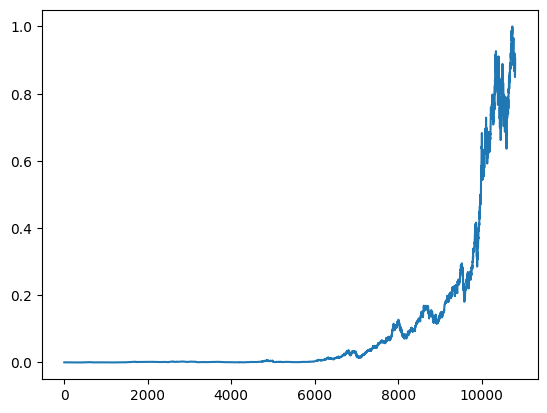

In [72]:
plt.plot(y)
plt.show()

In [75]:
act = 'relu'

model = Sequential([LSTM(64, activation = act, input_shape = (x.shape[1],x.shape[2]), return_sequences = True),
                    LSTM(32, activation = act, return_sequences = False),
                    Dropout(0.2),
                    Dense(y.shape[1])])

model.compile(optimizer = 'adam',
                loss = 'mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
hist = model.fit(x, y, epochs = 20, batch_size = 16, validation_split = 0.1)

Epoch 1/20
608/608 [==============================] - 4s 4ms/step - loss: 3.6160e-04 - val_loss: 0.0049
Epoch 2/20
608/608 [==============================] - 2s 4ms/step - loss: 1.6501e-04 - val_loss: 0.0194
Epoch 3/20
608/608 [==============================] - 2s 4ms/step - loss: 1.5128e-04 - val_loss: 0.0442
Epoch 4/20
608/608 [==============================] - 2s 4ms/step - loss: 1.5361e-04 - val_loss: 0.0457
Epoch 5/20
608/608 [==============================] - 2s 4ms/step - loss: 1.6431e-04 - val_loss: 0.0126
Epoch 6/20
608/608 [==============================] - 2s 4ms/step - loss: 1.4565e-04 - val_loss: 0.0127
Epoch 7/20
608/608 [==============================] - 2s 4ms/step - loss: 1.4171e-04 - val_loss: 0.0016
Epoch 8/20
608/608 [==============================] - 2s 4ms/step - loss: 1.6024e-04 - val_loss: 0.0012
Epoch 9/20
608/608 [==============================] - 2s 4ms/step - loss: 1.3691e-04 - val_loss: 0.0074
Epoch 10/20
608/608 [==============================] - 2s 4ms/st

C:\Users\pancakeFiles\AppData\Local\Temp\ipykernel_448\1822820563.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


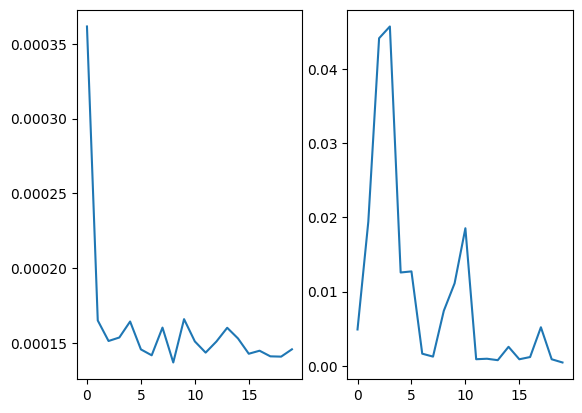

In [81]:
plt.title('loss')
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.subplot(122)
plt.plot(hist.history['val_loss'])
plt.show()

In [149]:
future_day = 900
pred = model.predict(x[-future_day:])
pred = scaler.inverse_transform(pred)[:,0]


29/29 [==============================] - 0s 2ms/step


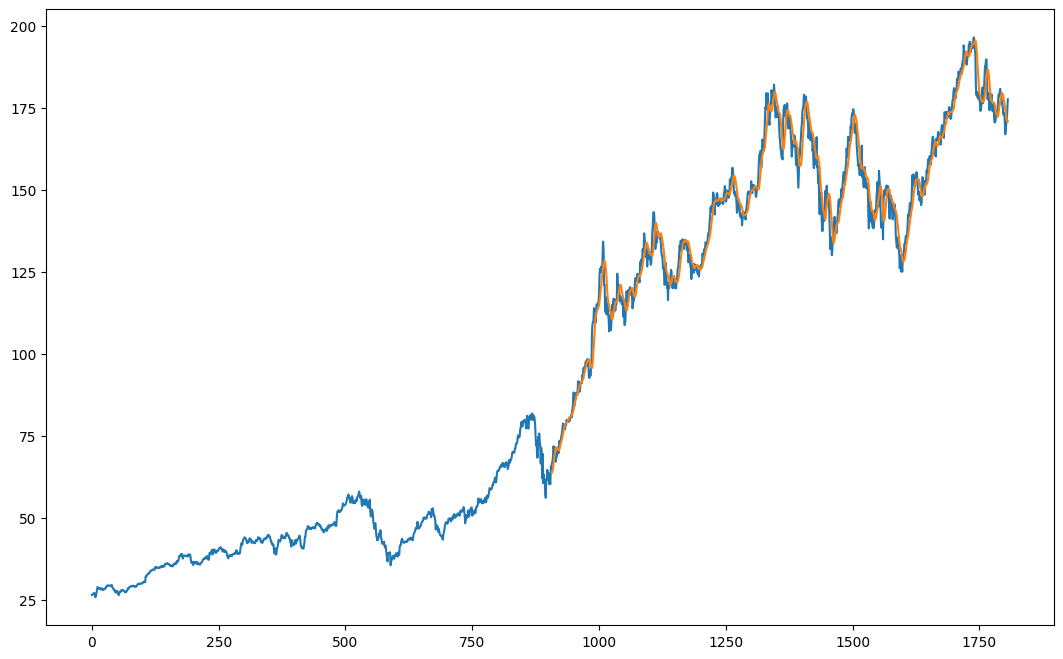

In [150]:
a = 9000
plt.figure(figsize = (13,8))
plt.plot(scaler.inverse_transform(y)[a:])
plt.plot(list(range(len(y[a:])))[-future_day:],pred) #list(range(len(y[a:])))[-future_day:]
plt.show()
print()